# GGIR use case 1

This use case requires the generation of two types of related sleep signals: rest and main bed period. Both signals appear in a time signal between 12:00 noon and 12:00 next day. Each signal consists of two binary signals: period starts and period ends. For reference, there is a larger [description of this use case](https://github.com/sequgen/sequgen/issues/21) as well as a [visualization](https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#42_Output_part_4) of the time signals (click on the tab `4.2.3 visualisation_sleep.pdf`).

## 1. Peak generation

The required time signals consist a series of peaks which can be generated with the sequgen functions. Let's start with importing the required functions.

In [1]:
import random
from sequgen.dimension import Dimension
from sequgen.parameter_space import ParameterSpace

sequgen only provides signals with a single peak, so we need to create our own function for generating signals with several peaks. Furthermore, the peaks need to satisfy two requirements: 1. peaks can not overlap each other, and 2. peaks cannot extend beyond the end of the available time frame. We need functions to check these constraints as well.

If a peak does not satisfy a constraint, it will be discarded and another peak will be generated. However, it is possible that there is no more room in the time frame for another peak that satifies the required constraints. To avoid entering an infinitive loop, we will only allow for 100 successive failed peak generation attempts.

In [2]:
MAXIMUM_FAILED_TRIES = 100


def peaks_overlap(peaks):
    peaks = peaks_sort(peaks)
    for i in range(0, len(peaks)-1):
        if peaks[i]['location'] + peaks[i]['width'] >= peaks[i+1]['location']:
            return(True)
    return(False)


def peaks_sort(peaks):
    return([ peak for peak in sorted(peaks, key=lambda p:p['location']) ])


def peak_extends_maximum(peak):
    return('maximum' in peak and peak['maximum'] < peak['location'] + peak['width']) 


def peaks_generate(parameter_space):
    peaks = []
    failed_tries = 0
    iterations = parameter_space.sample()["iterations"]
    while len(peaks) < iterations and failed_tries < MAXIMUM_FAILED_TRIES:
        new_peak = parameter_space.sample()
        if peak_extends_maximum(new_peak) or peaks_overlap(peaks + [new_peak]):
            failed_tries += 1
        else:
            peaks.append(new_peak)
            peaks = peaks_sort(peaks)
            failed_tries = 0
    return peaks

## 2. Signal functions

A signal consists of two main parts: main bed time, the time at night that a person is in bed, and resting times, several periods during the day when a person is resting. The function has six parameters: start and end point of the available start frame, minimum and maximum start of bed time and minimum and maximum length of the bed time period. The resting times are divided in three groups: pre-bed time rests, bed time rests and post-bed time rests.

In [3]:
def make_signal(start_time, end_time, 
                bed_time_start_minimum, bed_time_start_maximum, 
                bed_time_minimum, bed_time_maximum,
                bed_time_iterations_minimum, bed_time_iterations_maximum,
                pre_bed_time_iterations_minimum, pre_bed_time_iterations_maximum,
                post_bed_time_iterations_minimum, post_bed_time_iterations_maximum,
                bed_time_rest_minimum, bed_time_rest_maximum,
                other_rest_minimum, other_rest_maximum):
    bed_time = make_bed_time(bed_time_start_minimum, bed_time_start_maximum, bed_time_minimum, bed_time_maximum)
    pre_bed_time_rests = make_rests(start_time * 60, bed_time[0]['location'], 
                                    other_rest_minimum * 60, other_rest_maximum * 60, 
                                    pre_bed_time_iterations_minimum, pre_bed_time_iterations_maximum)
    bed_time_rests = make_rests(bed_time[0]['location'], bed_time[0]['location']+bed_time[0]['width'],
                                bed_time_rest_minimum * 60, bed_time_rest_maximum * 60,
                                bed_time_iterations_minimum, bed_time_iterations_maximum)
    post_bed_time_rests = make_rests(bed_time[0]['location']+bed_time[0]['width'], end_time*60,
                                     other_rest_minimum * 60, other_rest_maximum * 60,
                                     post_bed_time_iterations_minimum, post_bed_time_iterations_maximum)
    return(bed_time, (pre_bed_time_rests + bed_time_rests + post_bed_time_rests))

We create a function for generating an arbitrary bed time period that satisfies the constraints

In [4]:
def make_bed_time(bed_time_start_minimum, bed_time_start_maximum, bed_time_minimum, bed_time_maximum, maximum=None, iterations=1):
    if maximum == None:
        maximum = bed_time_start_maximum + bed_time_maximum
    parameter_space = ParameterSpace([
        Dimension("location", bed_time_start_minimum * 60, bed_time_start_maximum * 60),
        Dimension("width", bed_time_minimum * 60, bed_time_maximum * 60),
        Dimension("maximum", maximum * 60),
        Dimension("iterations", iterations),
    ])
    bed_time = peaks_generate(parameter_space)
    return(bed_time)

Next, we define a function for generating the rest times:

In [5]:
def make_rests(start_time, end_time, width_minimum, width_maximum, iterations_minimum, iterations_maximum):
    parameter_space = ParameterSpace([
        Dimension("location", start_time, end_time),
        Dimension("width", width_minimum, width_maximum),
        Dimension("maximum", end_time),
        Dimension("iterations", iterations_minimum, iterations_maximum),
    ])
    rests = peaks_generate(parameter_space)
    return(rests)

## 3. Plotting functions

We use these functions for plotting the time series.

In [7]:
import matplotlib.pyplot as plt


def plot_draw_graph(ax, start_time, end_time, data, color, label, height=1):
    for i in range(0, len(data)):
        period = data[i]
        if i == 0:
            ax.bar([period['location'] + 0.5 * period['width']], [height], width=period['width'], color=color, label=label)
        else:
            ax.bar([period['location'] + 0.5 * period['width']], [height], width=period['width'], color=color)
    ax.set_xlim(start_time, end_time)
    ax.set_ylim(min(0, 1.5*height), max(0, 1.5*height))
    ax.tick_params(left=False, labelleft=False)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.legend()

    
def plot(start_time, end_time, bed_time, rests):
    fig, axs = plt.subplots(2, 1, figsize=(10,3))
    plot_draw_graph(axs[0], start_time, end_time, rests, "C8", "rest periods")
    plot_draw_graph(axs[1], start_time, end_time, bed_time, "C7", "main bed time", height=-1)
    plt.show()

## 4. Export functions

And these functions convert the start and end points in the time series to a human-readable format.

In [8]:
def number2time(number):
    hours = int(number / 60)
    minutes = int(number - (hours*60))
    return(str(hours)+":"+str(minutes).zfill(2))
    

def print_data(data, data_name):
    print(data_name+ " starts:", end=" ")
    for peak in data:
        print(number2time(round(peak['location'])), end=" ")
    print("\n" + data_name + " ends:  ", end=" ")
    for peak in data:
        print(number2time(round(peak['location'] + peak['width'])), end=" ")
    print()

## 5. Generate, plot and export

Finally we generate the time series: from a start of noon (12:00) until noon next day (36:00) with bed time starting between 22:00 and 02:00 (26:00) and lasting between six and nine hours. Bed time include between one and three rest periods while before bed time there can be up to five rest periods and after bed time at most one. Bed time rests last between two and eight hours while other rests last between 0.2 hours and 0.5 hours. We check the time series by plotting it and inspecting the start and end points of the different periods.

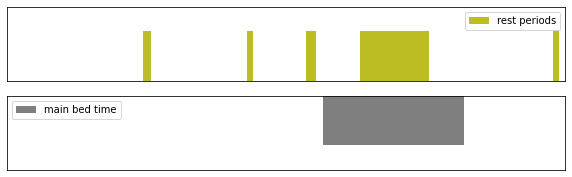

    Rest starts: 17:49 22:18 24:51 27:11 35:30 
    Rest ends:   18:12 22:35 25:18 30:08 35:43 
Bed time starts: 25:34 
Bed time ends:   31:40 


In [9]:
bed_time, rests = make_signal(start_time=12, end_time=36, 
                              bed_time_start_minimum=22, bed_time_start_maximum=26, 
                              bed_time_minimum=6, bed_time_maximum=9,
                              bed_time_iterations_minimum=1, bed_time_iterations_maximum=3,
                              pre_bed_time_iterations_minimum=0, pre_bed_time_iterations_maximum=5,
                              post_bed_time_iterations_minimum=0, post_bed_time_iterations_maximum=1,
                              bed_time_rest_minimum=2, bed_time_rest_maximum=8,
                              other_rest_minimum=0.2, other_rest_maximum=0.5)

plot(12 * 60, 36*60, bed_time, rests)

print_data(rests,    "    Rest")
print_data(bed_time, "Bed time")